# Análise Generalizada de SAM (Spectral Angle Mapper)

Este notebook permite configurar parâmetros operacionais (RPM, Diâmetro de Falha) e realizar automaticamente:
1.  **Busca de Sinais Reais**: Seleção robusta de múltiplos sinais de referência no dataset.
2.  **Geração de Sinais Sintéticos**: Criação de sinais via métodos FFT e Impulso para as condições especificadas.
3.  **Comparação Quantitativa**: Cálculo da métrica SAM par-a-par e estatística (Média/Desvio).

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.spatial.distance import cosine
import random

# Adicionar src ao path para importar módulos do projeto
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

import segment_and_split_data as ssd
import generate_synthetic_data as gsd
import generate_impulse_data as gid
import bearing_utils as bu

import importlib
importlib.reload(bu)
importlib.reload(gsd)
importlib.reload(gid)
importlib.reload(ssd)
print('Modules reloaded.')

Iniciando a leitura e segmentação dos arquivos em 'c:\Users\Cliente\Documents\GitHub\TCC\data'...
Dados normais serão divididos (80% treino / 20% teste).
Dados de falha real irão 100% para o teste.

--- Processo Concluído! ---
Total de segmentos de TREINO (APENAS 80% normais): 470
Total de segmentos de TESTE (falhas reais + 20% normais): 3184

Exemplo de um segmento de TREINO (chave: '1730_Normal_DE_treino_seg_0'):
   amplitude   arquivo_origem  rotacao_rpm tipo_falha diametro_falha  \
0   0.014603  1730_Normal.npz         1730     Normal            N/A   
1   0.054449  1730_Normal.npz         1730     Normal            N/A   
2   0.107646  1730_Normal.npz         1730     Normal            N/A   
3   0.133722  1730_Normal.npz         1730     Normal            N/A   
4   0.112652  1730_Normal.npz         1730     Normal            N/A   

  local_sensor  
0    Drive End  
1    Drive End  
2    Drive End  
3    Drive End  
4    Drive End  

Exemplo de um segmento de TESTE (chave: '1730

## 1. Configuração de Parâmetros
Defina aqui as condições operacionais para a análise.

In [3]:
# --- Parâmetros de Entrada ---
TARGET_RPM = 1750          # Rotação do eixo (Ex: 1730, 1750, 1772, 1797)
TARGET_DIAMETER_MM = 0.5   # Diâmetro da falha alvo em mm (aprox 0.021")
NUM_SAMPLES = 20            # Número de amostras reais para usar na média do SAM

# --- Constantes do Sistema ---
FS = 12000                 # Frequência de Amostragem (Hz)
N_POINTS = 4096            # Tamanho do segmento

In [27]:
# --- Configuração de Sweep de Parâmetros ---

# RPMs disponíveis no dataset CWRU
RPMS = [1730, 1750, 1772, 1797]

# Diâmetros de falha em mm (aproximadamente 0.007", 0.014", 0.021", 0.028")
DIAMETERS_MM = [0.1778, 0.3556, 0.5334, 0.7112]

# Labels convenientes para visualização
CWru_DIA_MAP = {
    0.1778: '0.007"',
    0.3556: '0.014"',
    0.5334: '0.021"',
    0.7112: '0.028"'
}

# Grade de K por tipo de falha (valores expandidos com foco em menores amplitudes)
K_GRID = {
    'OR': [0.01, 0.02, 0.05, 0.1],   # Outer race (Pista Externa)
    'IR': [0.01, 0.05, 0.5, 0.8, 1.0],      # Inner race (Pista Interna)
    'B':  [0.005, 0.01, 0.02, 0.03, 0.05, 0.08]       # Ball (Esfera)
}


## 2. Funções Auxiliares
Funções para cálculo do SAM, espectro e filtragem de dados.

In [13]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from general_sam_analysis_utils import (
    calcular_sam_graus,
    get_mag_spectrum,
    get_real_signals_metadata_batch,
    get_normal_signal,
    pad_or_trim,
    apply_antialiasing_filter,
    apply_hanning_window,
    limit_spectrum_frequency,
    apply_lowpass_filter  # <--- NOVA FUNÇÃO
)

# Obs.: a geração do sinal por impulso agora vem de `generate_impulse_data.py` (importado como `gid`).

## 4. Visualização Agregada dos Resultados

A partir de `results_df`, podemos criar visualizações agregadas para entender o efeito de RPM, diâmetro, K e tipo de falha sobre o SAM médio.


In [29]:
# 3. Execução da Análise em Sweep (RPM × Diâmetro × K) + Baseline (Normal vs Real)

results = []

falhas = [
    ('Pista Externa', 'OR', 'outer'),
    ('Pista Interna', 'IR', 'inner'),
    ('Esfera',       'B',  'ball')
]

if 'FREQ_MAX_VALUES' not in locals():
    FREQ_MAX_VALUES = [1200]

print("Iniciando sweep de parâmetros e cálculo de baseline (Normal vs Real)...\n")

# --- Calcular Frequências Naturais do Rolamento (Uma vez) ---
nat_freqs_df = bu.get_bearing_natural_frequencies()

for freq_max in FREQ_MAX_VALUES:
    UPPER_FREQ_LIMIT = freq_max
    print(f"\n--- Iniciando análise para Limite Superior de Frequência: {UPPER_FREQ_LIMIT} Hz ---")

    for rpm in RPMS:
        # 1. Obter Ruído de fundo (Normal) para este RPM
        sinal_normal = get_normal_signal(ssd.dicionario_teste, rpm, N_POINTS)
        
        # --- PREPARAÇÃO DO ESPECTRO NORMAL (BASELINE) ---
        sig_nat_filt = apply_antialiasing_filter(sinal_normal, FS)
        sig_nat_filt = apply_lowpass_filter(sig_nat_filt, FS, cutoff_freq=1200)
        sig_nat_win = apply_hanning_window(sig_nat_filt)
        spec_nat_full = get_mag_spectrum(sig_nat_win)

        # Calcular frequências características para Limite Inferior
        t_inner = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'inner')
        t_outer = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'outer')
        t_ball  = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'ball')
        
        bpfi = t_inner['frequencies']['defect_freq_hz']
        bpfo = t_outer['frequencies']['defect_freq_hz']
        bsf  = t_ball['frequencies']['defect_freq_hz'] 
        
        # Limite Inferior: 0.9 * min(todas as freq falha)
        min_char_freq = min(bpfi, bpfo, bsf)
        LOWER_FREQ_LIMIT = 0.9 * min_char_freq

        # Pre-calcular eixo de frequências
        freq_axis = fftfreq(N_POINTS, 1/FS)[:N_POINTS//2]
        
        # Limitar espectro do Normal
        _, spec_nat_lim = limit_spectrum_frequency(freq_axis, spec_nat_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)

        for diam_mm in DIAMETERS_MM:
            for nome, type_code, gen_type in falhas:
                # Grade de K dependente do tipo de falha
                for k_val in K_GRID[type_code]:
                    # 1. Obter Sinais Reais de Referência
                    refs = get_real_signals_metadata_batch(ssd.dicionario_teste, rpm, type_code, diam_mm, NUM_SAMPLES)
                    num_refs = len(refs)

                    # 2. Calcular Frequência de Falha (para Impulso)
                    tandon_coeffs = bu.calculate_tandon_coefficients(diam_mm, rpm, gen_type)
                    char_freq = tandon_coeffs['frequencies']['defect_freq_hz']

                    # --- Geração Sintética (Tandon e Impulso) ---
                    # (Mesmo processo de antes...)
                    try:
                        sig_fft_pure, sig_fft_final = gsd.gerar_sinal_tandon_completo(
                            fs=FS, n_points=N_POINTS, diametro_mm=diam_mm, rpm=rpm,
                            tipo_falha=nome, k_val=k_val, sinal_normal=sinal_normal,
                        )
                        sig_fft_final = apply_antialiasing_filter(sig_fft_final, FS)
                        sig_fft_final = apply_lowpass_filter(sig_fft_final, FS, cutoff_freq=1200)
                        sig_fft_final_win = apply_hanning_window(sig_fft_final)
                    except Exception as e:
                        sig_fft_final_win = np.zeros(N_POINTS)

                    try:
                        sig_imp_pure = gid.gerar_sinal_impulso_completo(
                            fs=FS, duration_points=N_POINTS, defect_freq_hz=char_freq
                        )
                        sig_imp_final = sinal_normal + (k_val * sig_imp_pure)
                        sig_imp_final = apply_antialiasing_filter(sig_imp_final, FS)
                        sig_imp_final = apply_lowpass_filter(sig_imp_final, FS, cutoff_freq=1200)
                        sig_imp_final_win = apply_hanning_window(sig_imp_final)
                    except Exception as e:
                        sig_imp_final_win = np.zeros(N_POINTS)

                    # 3. Calcular SAM e registrar resultados
                    sam_fft_vals = []
                    sam_imp_vals = []
                    sam_real_vs_normal_vals = [] # Lista para armazenar SAM(Real vs Normal)

                    spec_syn_fft_full = get_mag_spectrum(sig_fft_final_win)
                    spec_syn_imp_full = get_mag_spectrum(sig_imp_final_win)

                    # LIMITAR ESPECTROS SINTÉTICOS
                    _, spec_syn_fft_lim = limit_spectrum_frequency(freq_axis, spec_syn_fft_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)
                    _, spec_syn_imp_lim = limit_spectrum_frequency(freq_axis, spec_syn_imp_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)

                    for _, sig_real in refs:
                        # Processar sinal Real
                        sig_real_filt = apply_antialiasing_filter(sig_real, FS)
                        sig_real_filt = apply_lowpass_filter(sig_real_filt, FS, cutoff_freq=1200)
                        sig_real_win = apply_hanning_window(sig_real_filt)
                        spec_real_full = get_mag_spectrum(sig_real_win)
                        _, spec_real_lim = limit_spectrum_frequency(freq_axis, spec_real_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)

                        # A) SAM: Real vs Sintético (Validação do Modelo)
                        sam_fft_vals.append(calcular_sam_graus(spec_real_lim, spec_syn_fft_lim))
                        sam_imp_vals.append(calcular_sam_graus(spec_real_lim, spec_syn_imp_lim))
                        
                        # B) SAM: Real vs Normal (Baseline / Severidade da Falha Real)
                        # Quanto maior esse valor, mais diferente a falha real é do normal.
                        sam_real_vs_normal_vals.append(calcular_sam_graus(spec_real_lim, spec_nat_lim))

                    # Calcular médias
                    mean_fft = float(np.mean(sam_fft_vals)) if sam_fft_vals else np.nan
                    std_fft = float(np.std(sam_fft_vals)) if sam_fft_vals else np.nan

                    mean_imp = float(np.mean(sam_imp_vals)) if sam_imp_vals else np.nan
                    std_imp = float(np.std(sam_imp_vals)) if sam_imp_vals else np.nan
                    
                    # Média do Baseline para este grupo de sinais reais
                    mean_real_vs_normal = float(np.mean(sam_real_vs_normal_vals)) if sam_real_vs_normal_vals else np.nan

                    dia_label = CWru_DIA_MAP.get(min(CWru_DIA_MAP.keys(), key=lambda k: abs(k - diam_mm)), f"{diam_mm:.4f}m")

                    # Armazenar resultados
                    # Nota: 'sam_real_vs_normal_deg' será igual para as linhas FFT e Impulso do mesmo caso real,
                    # mas repetimos para facilitar plotagem lado a lado se necessário.
                    results.append({
                        'rpm': rpm,
                        'diameter_mm': diam_mm,
                        'diameter_label': dia_label,
                        'fault_name': nome,
                        'fault_code': type_code,
                        'freq_max': freq_max,
                        'method': 'fft',
                        'k': k_val,
                        'num_refs': num_refs,
                        'sam_mean_deg': mean_fft,
                        'sam_std_deg': std_fft,
                        'sam_real_vs_normal_deg': mean_real_vs_normal # <--- COLUNA CORRETA
                    })

                    results.append({
                        'rpm': rpm,
                        'diameter_mm': diam_mm,
                        'diameter_label': dia_label,
                        'fault_name': nome,
                        'fault_code': type_code,
                        'freq_max': freq_max,
                        'method': 'impulse',
                        'k': k_val,
                        'num_refs': num_refs,
                        'sam_mean_deg': mean_imp,
                        'sam_std_deg': std_imp,
                        'sam_real_vs_normal_deg': mean_real_vs_normal # <--- COLUNA CORRETA
                    })

# Consolidar em DataFrame
results_df = pd.DataFrame(results)
print(f"Sweep concluído. Total de linhas em results_df: {len(results_df)}")
display(results_df.head())

Iniciando sweep de parâmetros e cálculo de baseline (Normal vs Real)...


--- Iniciando análise para Limite Superior de Frequência: 1200 Hz ---
Sweep concluído. Total de linhas em results_df: 480


,rpm,diameter_mm,diameter_label,fault_name,fault_code,freq_max,method,k,num_refs,sam_mean_deg,sam_std_deg,sam_real_vs_normal_deg
0,1730,0.1778,"0.007""",Pista Externa,OR,1200,fft,0.01,20,61.026211,2.989741,62.517496
1,1730,0.1778,"0.007""",Pista Externa,OR,1200,impulse,0.01,20,62.534304,2.348692,62.517496
2,1730,0.1778,"0.007""",Pista Externa,OR,1200,fft,0.02,20,62.211846,4.038166,63.002490
3,1730,0.1778,"0.007""",Pista Externa,OR,1200,impulse,0.02,20,63.025371,2.999577,63.002490
4,1730,0.1778,"0.007""",Pista Externa,OR,1200,fft,0.05,20,65.030160,7.108968,64.280166


In [30]:
# --- Nova Seção: Comparação Baseline (Sinal Natural vs Falha Real) ---

print("Iniciando análise de Baseline: Sinal Natural vs Falha Real...\n")

results_baseline = []

# Garantindo que parâmetros de loop estejam definidos (caso executado separadamente)
# Se já estiverem definidos anteriormente no notebook, esses valores serão usados.
if 'FREQ_MAX_VALUES' not in locals():
    FREQ_MAX_VALUES = [1200]

for freq_max in FREQ_MAX_VALUES:
    UPPER_FREQ_LIMIT = freq_max
    
    for rpm in RPMS:
        # 1. Obter Sinal Natural (Normal / Ruído de Fundo)
        # Este sinal serve como nossa referência "Sem Falha"
        sinal_natural = get_normal_signal(ssd.dicionario_teste, rpm, N_POINTS)
        
        # 2. Aplicar a mesma cadeia de filtros usada nos outros métodos
        sig_nat_filt = apply_antialiasing_filter(sinal_natural, FS)
        sig_nat_filt = apply_lowpass_filter(sig_nat_filt, FS, cutoff_freq=1200)
        sig_nat_win = apply_hanning_window(sig_nat_filt)
        
        # 3. Obter Espectro do Sinal Natural
        spec_nat_full = get_mag_spectrum(sig_nat_win)
        
        # Calcular eixo de frequências
        freq_axis = fftfreq(N_POINTS, 1/FS)[:N_POINTS//2]

        # Calcular limite inferior de frequência (baseado nas freq. características do rolamento)
        t_inner = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'inner')
        t_outer = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'outer')
        t_ball  = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'ball')
        min_char_freq = min(t_inner['frequencies']['defect_freq_hz'], 
                            t_outer['frequencies']['defect_freq_hz'], 
                            t_ball['frequencies']['defect_freq_hz'])
        LOWER_FREQ_LIMIT = 0.9 * min_char_freq
        
        # Limitar espectro do Natural
        _, spec_nat_lim = limit_spectrum_frequency(freq_axis, spec_nat_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)

        for diam_mm in DIAMETERS_MM:
            # Encontrar label do diâmetro (tratando flutuação de float)
            dia_key = min(CWru_DIA_MAP.keys(), key=lambda k: abs(k - diam_mm))
            dia_label = CWru_DIA_MAP.get(dia_key, f"{diam_mm:.4f}m")
            
            for nome, type_code, gen_type in falhas:
                # 4. Obter Sinais Reais de Referência (Falha Real)
                refs = get_real_signals_metadata_batch(ssd.dicionario_teste, rpm, type_code, diam_mm, NUM_SAMPLES)
                
                sam_vals = []
                for _, sig_real in refs:
                    # Filtros no sinal Real
                    sig_real_filt = apply_antialiasing_filter(sig_real, FS)
                    sig_real_filt = apply_lowpass_filter(sig_real_filt, FS, cutoff_freq=1200)
                    sig_real_win = apply_hanning_window(sig_real_filt)
                    spec_real_full = get_mag_spectrum(sig_real_win)
                    
                    # Limitar espectro do Real
                    _, spec_real_lim = limit_spectrum_frequency(freq_axis, spec_real_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)
                    
                    # 5. Calcular SAM: Quão similar é a FALHA REAL comparada ao SINAL NATURAL?
                    # SAM alto = Falha muito distinta do normal (Fácil detecção)
                    # SAM baixo = Falha parecida com normal (Difícil detecção)
                    sam_vals.append(calcular_sam_graus(spec_real_lim, spec_nat_lim))
                
                if sam_vals:
                    mean_sam = float(np.mean(sam_vals))
                    std_sam = float(np.std(sam_vals))
                else:
                    mean_sam, std_sam = np.nan, np.nan
                
                results_baseline.append({
                    'rpm': rpm,
                    'diameter_mm': diam_mm,
                    'diameter_label': dia_label,
                    'fault_name': nome,
                    'fault_code': type_code,
                    'freq_max': freq_max,
                    'method': 'natural_baseline', # Identificador do método
                    'k': 0.0, # N/A para baseline, mas mantido para consistência
                    'num_refs': len(refs),
                    'sam_mean_deg': mean_sam,
                    'sam_std_deg': std_sam
                })

# Criar DataFrame e exibir
df_baseline = pd.DataFrame(results_baseline)
print(f"Análise de Baseline concluída. Total de linhas: {len(df_baseline)}")
print("Amostra dos resultados (Natural vs Real):")
display(df_baseline.head())

# Opcional: Se quiser juntar com o dataframe principal 'results_df' gerado anteriormente:
# if 'results_df' in locals():
#     results_df_completo = pd.concat([results_df, df_baseline], ignore_index=True)
#     print("DataFrames concatenados em 'results_df_completo'.")

Iniciando análise de Baseline: Sinal Natural vs Falha Real...

Análise de Baseline concluída. Total de linhas: 48
Amostra dos resultados (Natural vs Real):


,rpm,diameter_mm,diameter_label,fault_name,fault_code,freq_max,method,k,num_refs,sam_mean_deg,sam_std_deg
0,1730,0.1778,"0.007""",Pista Externa,OR,1200,natural_baseline,0.0,20,65.374695,3.475414
1,1730,0.1778,"0.007""",Pista Interna,IR,1200,natural_baseline,0.0,20,68.268112,6.461396
2,1730,0.1778,"0.007""",Esfera,B,1200,natural_baseline,0.0,20,62.427059,3.666602
3,1730,0.3556,"0.014""",Pista Externa,OR,1200,natural_baseline,0.0,20,65.033141,1.836914
4,1730,0.3556,"0.014""",Pista Interna,IR,1200,natural_baseline,0.0,20,67.036701,3.988934


Visualização Final e Detalhamento FFT



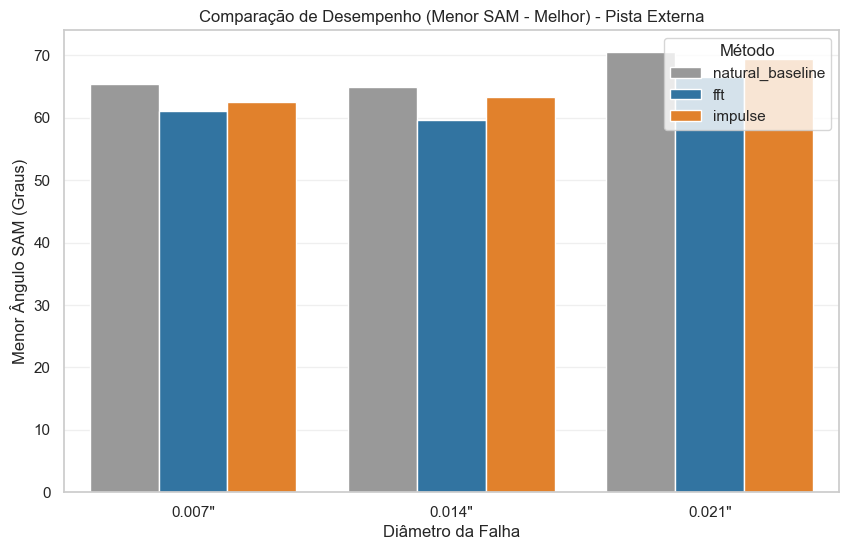

--- Melhores Configurações FFT para Pista Externa ---


,diameter_label,rpm,k,sam_mean_deg
0,"0.007""",1730,0.01,61.026211
1,"0.014""",1730,0.02,59.631876
2,"0.021""",1730,0.02,66.504089


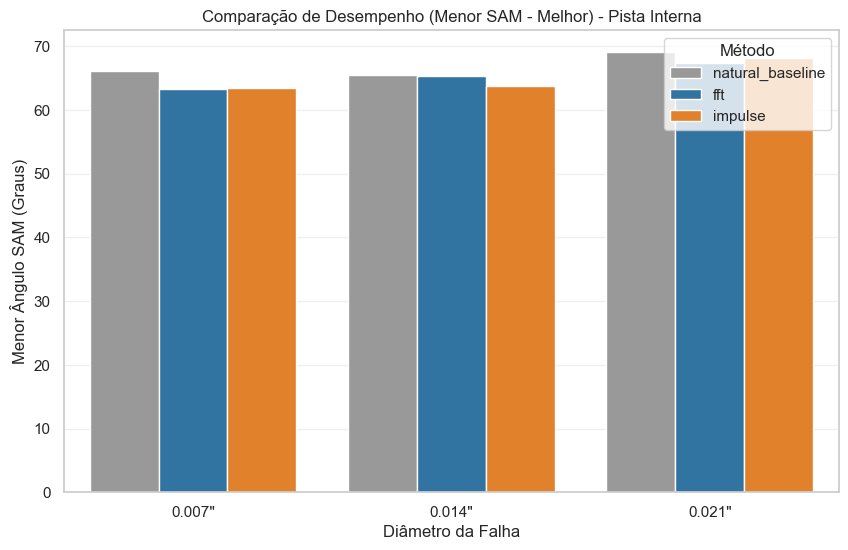

--- Melhores Configurações FFT para Pista Interna ---


,diameter_label,rpm,k,sam_mean_deg
0,"0.007""",1797,0.05,63.287394
1,"0.014""",1730,0.05,65.427906
2,"0.021""",1730,0.80,67.463368


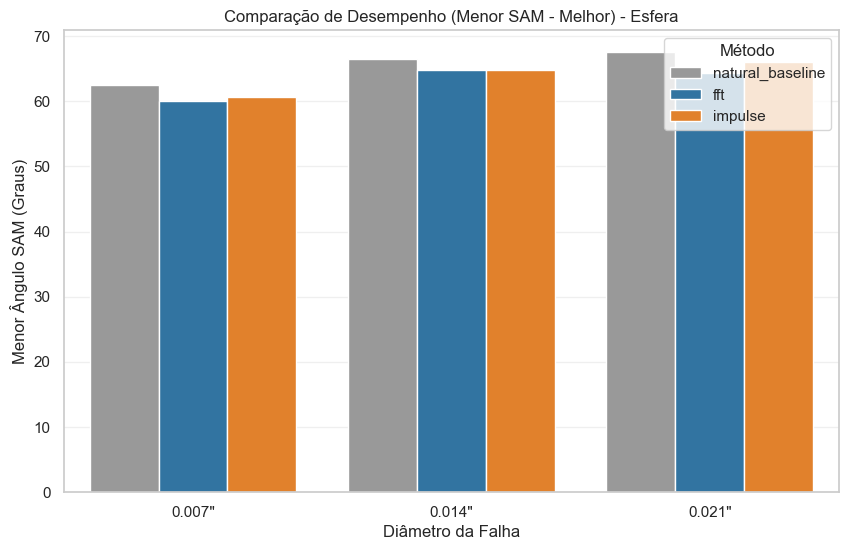

--- Melhores Configurações FFT para Esfera ---


,diameter_label,rpm,k,sam_mean_deg
0,"0.007""",1772,0.03,60.053596
1,"0.014""",1730,0.01,64.742598
2,"0.021""",1772,0.02,64.346309


In [31]:
# --- Visualização Unificada + Tabelas FFT ---

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Visualização Final e Detalhamento FFT\n")

if 'results_df' in locals() and 'df_baseline' in locals():
    # 1. Concatenar DataFrames de Resultados
    cols_interest = ['rpm', 'diameter_mm', 'diameter_label', 'fault_name', 
                     'method', 'sam_mean_deg', 'k'] # Adicionado 'k' para a tabela
    
    # Baseline não tem 'k', então preenchemos com 0 ou NaN
    df_syn = results_df[cols_interest].copy()
    df_base = df_baseline[cols_interest].copy()
    if 'k' not in df_base.columns: df_base['k'] = 0.0

    df_final = pd.concat([df_syn, df_base], ignore_index=True)
    
    unique_faults = df_final['fault_name'].unique()

    for fault in unique_faults:
        # Filtrar por defeito
        df_view = df_final[df_final['fault_name'] == fault].copy()
        df_view = df_view.dropna(subset=['sam_mean_deg'])
        
        if df_view.empty:
            continue

        # Selecionar MELHOR configuração (Mínimo SAM) para cada método/diâmetro
        best_indices = df_view.groupby(['method', 'diameter_label'])['sam_mean_deg'].idxmin()
        best_data = df_view.loc[best_indices].sort_values(by=['diameter_mm', 'method'])

        # --- PLOTAGEM ---
        plt.figure(figsize=(10, 6))
        hue_order = ['natural_baseline', 'fft', 'impulse']
        custom_palette = {'natural_baseline': '#999999', 'fft': '#1f77b4', 'impulse': '#ff7f0e'}

        sns.barplot(
            data=best_data, 
            x='diameter_label', 
            y='sam_mean_deg', 
            hue='method',
            hue_order=[h for h in hue_order if h in best_data['method'].values],
            palette=custom_palette
        )
        plt.title(f'Comparação de Desempenho (Menor SAM - Melhor) - {fault}')
        plt.xlabel('Diâmetro da Falha')
        plt.ylabel('Menor Ângulo SAM (Graus)')
        plt.grid(True, axis='y', alpha=0.3)
        plt.legend(title='Método')
        plt.show()

        # --- TABELA DE DETALHES (SÓ FFT) ---
        print(f"--- Melhores Configurações FFT para {fault} ---")
        
        # Filtrar apenas as linhas de FFT que foram selecionadas como "melhores" (best_data)
        fft_details = best_data[best_data['method'] == 'fft'].copy()
        
        if not fft_details.empty:
            # Selecionar e renomear colunas para exibição limpa
            display_cols = ['diameter_label', 'rpm', 'k', 'sam_mean_deg']
            fft_table = fft_details[display_cols].reset_index(drop=True)
            display(fft_table)
        else:
            print("Nenhum dado FFT válido encontrado para este defeito.")
        
        print("\n" + "="*80 + "\n")

else:
    print("ERRO: Execute as células de 'Sweep' e 'Baseline' antes desta.")